# ConvMixer

~~Convolutions~~ ~~Attention~~ ~~MLPs~~ Patches Are All You Need? 🤷‍♂️

ICLR 2022 [submission](https://openreview.net/forum?id=TVHS5Y4dNvM)

https://github.com/tmp-iclr/convmixer

ConvMixer:
- directly operates on patches
- maintains an equal resolution and size representation throughout all layers
- does no downsampling of the representation at successive layers
- separates channel-wise mixing from the spatial mixing of information

```python
def ConvMixr(h,d,k,p,n):
    S,C,A=Sequential,Conv2d,lambda x:S(x,GELU(),BatchNorm2d(h))
    R=type('',(S,),{'forward':lambda s,x:s[0](x)+x})
    return S(A(C(3,h,p,p)),*[S(R(A(C(h,h,k,groups=h,padding=k//2))),A(C(h,h,1))) for i
        in range(d)],AdaptiveAvgPool2d((1,1)),Flatten(),Linear(h,n))
```

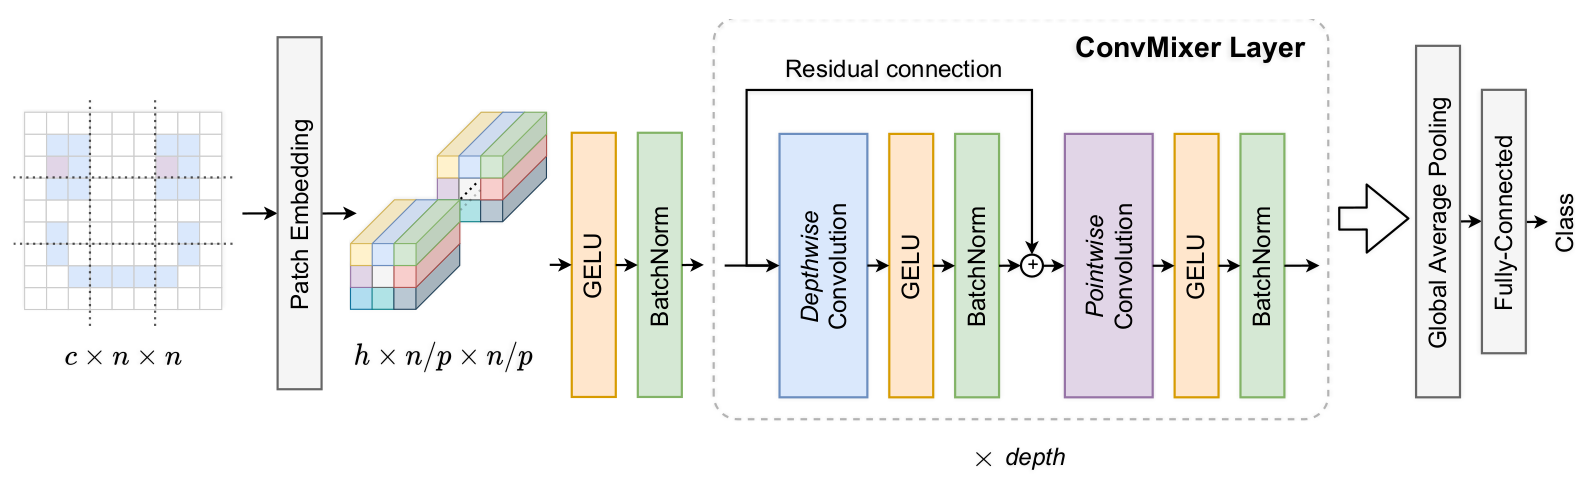

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1
EPOCHS = 100

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [7]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [8]:
class Residual(nn.Module):
    def __init__(self, residual):
        super().__init__()
        self.residual = residual
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [9]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
            nn.GELU(),
            nn.BatchNorm2d(out_channels)
        )

ConvMixer

In [10]:
class ConvMixerLayer(nn.Sequential):
    def __init__(self, channels, kernel_size):
        super().__init__(
            Residual(ConvBlock(channels, channels, kernel_size, groups=channels)), # Depthwise
            ConvBlock(channels, channels, 1) # Pointwise
        )

In [11]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [12]:
class ConvMixer(nn.Sequential):
    def __init__(self, classes, channels, depth, patch_size, kernel_size, in_channels=3, head_p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, channels, patch_size, stride=patch_size), # patch embedding
            *[ ConvMixerLayer(channels, kernel_size) for _ in range(depth) ],
            Head(channels, classes, head_p_drop)
        )

In [13]:
model = ConvMixer(NUM_CLASSES, channels=256, depth=8, patch_size=1, kernel_size=7, head_p_drop=0.3)

In [14]:
model.apply(init_linear);

In [15]:
model.to(DEVICE);

In [16]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 641,042


## Training

### Optimizer

In [17]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.BatchNorm2d,)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [18]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [19]:
loss = nn.CrossEntropyLoss()

In [20]:
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [21]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [22]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [23]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [24]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [25]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [26]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [27]:
history = defaultdict(list)

In [28]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [31]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.966; val: loss 1.921 accuracy 0.297
2/100 - train: loss 1.821; val: loss 1.803 accuracy 0.345
3/100 - train: loss 1.663; val: loss 1.623 accuracy 0.401
4/100 - train: loss 1.558; val: loss 1.499 accuracy 0.456
5/100 - train: loss 1.439; val: loss 1.362 accuracy 0.507
6/100 - train: loss 1.315; val: loss 1.259 accuracy 0.544
7/100 - train: loss 1.218; val: loss 1.208 accuracy 0.568
8/100 - train: loss 1.122; val: loss 1.100 accuracy 0.608
9/100 - train: loss 1.029; val: loss 0.988 accuracy 0.651
10/100 - train: loss 0.941; val: loss 0.901 accuracy 0.681
11/100 - train: loss 0.785; val: loss 0.838 accuracy 0.713
12/100 - train: loss 0.743; val: loss 0.732 accuracy 0.750
13/100 - train: loss 0.733; val: loss 0.657 accuracy 0.775
14/100 - train: loss 0.632; val: loss 0.669 accuracy 0.768
15/100 - train: loss 0.585; val: loss 0.607 accuracy 0.793
16/100 - train: loss 0.530; val: loss 0.567 accuracy 0.806
17/100 - train: loss 0.543; val: loss 0.567 accuracy 0.814
18/100

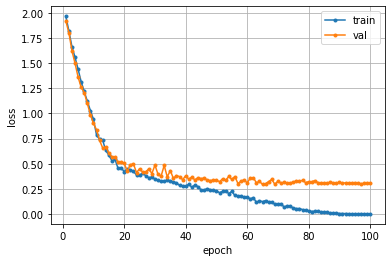

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

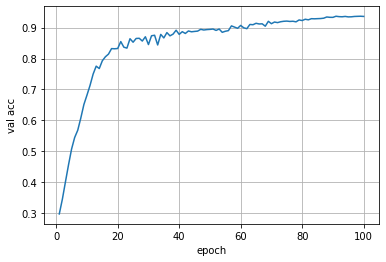

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

## Improved model

### Model

In [9]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
        )

In [10]:
class ConvMixerLayer(nn.Sequential):
    def __init__(self, channels, kernel_size):
        num_conv = (kernel_size - 3) // 2 + 1
        super().__init__(
            Residual( # Depthwise
                nn.Sequential(*[ConvBlock(channels, channels, 3, groups=channels) for _ in range(num_conv)])
            ),
            Residual(ConvBlock(channels, channels, 1)) # Pointwise
        )

In [11]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [12]:
class ConvMixer(nn.Sequential):
    def __init__(self, classes, channels, depth, patch_size, kernel_size, in_channels=3, head_p_drop=0.):
        super().__init__(
            nn.Conv2d(in_channels, channels, patch_size, stride=patch_size), # patch embedding
            *[ ConvMixerLayer(channels, kernel_size) for _ in range(depth) ],
            Head(channels, classes, head_p_drop)
        )

In [13]:
model = ConvMixer(NUM_CLASSES, channels=256, depth=8, patch_size=1, kernel_size=7, head_p_drop=0.3)

In [14]:
model.apply(init_linear);

In [15]:
model.to(DEVICE);

In [16]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 608,282


### Training

Configuration

In [2]:
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

Setup trainer

In [22]:
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [23]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [24]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [25]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [26]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [27]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [28]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [29]:
history = defaultdict(list)

In [30]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

Start training

In [31]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.311; val: loss 1.245 accuracy 0.552
2/100 - train: loss 1.096; val: loss 1.008 accuracy 0.638
3/100 - train: loss 0.911; val: loss 0.874 accuracy 0.691
4/100 - train: loss 0.850; val: loss 0.772 accuracy 0.733
5/100 - train: loss 0.728; val: loss 0.682 accuracy 0.764
6/100 - train: loss 0.677; val: loss 0.617 accuracy 0.787
7/100 - train: loss 0.622; val: loss 0.596 accuracy 0.797
8/100 - train: loss 0.602; val: loss 0.548 accuracy 0.815
9/100 - train: loss 0.523; val: loss 0.535 accuracy 0.822
10/100 - train: loss 0.533; val: loss 0.528 accuracy 0.817
11/100 - train: loss 0.466; val: loss 0.484 accuracy 0.840
12/100 - train: loss 0.463; val: loss 0.513 accuracy 0.835
13/100 - train: loss 0.489; val: loss 0.495 accuracy 0.839
14/100 - train: loss 0.432; val: loss 0.468 accuracy 0.838
15/100 - train: loss 0.422; val: loss 0.488 accuracy 0.837
16/100 - train: loss 0.453; val: loss 0.440 accuracy 0.854
17/100 - train: loss 0.449; val: loss 0.544 accuracy 0.826
18/100

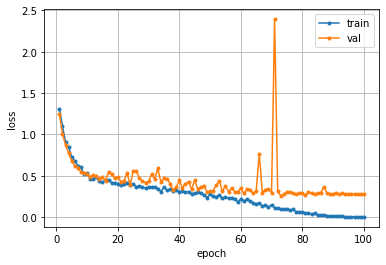

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

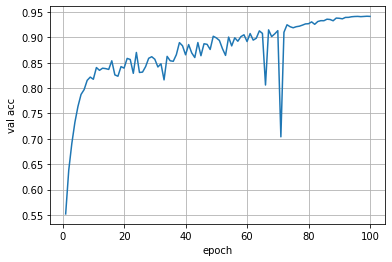

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()